#**Gen AI assignment 3**
#**M.Hamza 2021378**

#**import libraries**

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, PReLU, Add, Lambda
from tensorflow.keras.layers import LeakyReLU, Flatten, Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
import os
import time

#**Dataset and Preprocessing**

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/incomplete.LNB7CD_2.0.0/div2k-train.tfrecord*...:   0%|  …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/incomplete.LNB7CD_2.0.0/div2k-validation.tfrecord*...:   …

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.
Low-Res Images: (40, 64, 64, 3), High-Res Images: (40, 256, 256, 3)


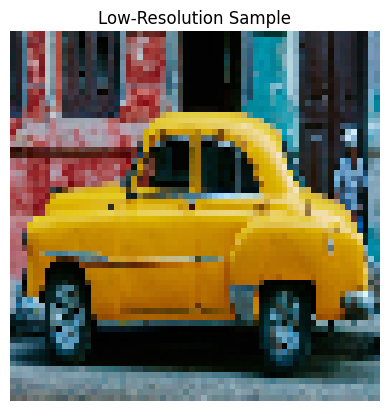

In [ ]:
# Fixed dimensions for Low-Resolution (LR) and High-Resolution (HR) images
LR_SIZE = (64, 64)   # Resize all low-res images to 64x64
HR_SIZE = (256, 256) # Resize all high-res images to 256x256

# Load a small subset of DIV2K
dataset = tfds.load("div2k/bicubic_x4", split="train[:5%]", as_supervised=True)  # Use only 5% of data

lr_images, hr_images = [], []

# Convert dataset to NumPy arrays (normalize 0-1) and **resize all images**
for lr, hr in tfds.as_numpy(dataset):
    lr_resized = cv2.resize(lr, LR_SIZE, interpolation=cv2.INTER_CUBIC)
    hr_resized = cv2.resize(hr, HR_SIZE, interpolation=cv2.INTER_CUBIC)

    lr_images.append(lr_resized.astype(np.float32) / 255.0)  # Normalize
    hr_images.append(hr_resized.astype(np.float32) / 255.0)

# Convert lists to NumPy arrays **after resizing**
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

print(f"Low-Res Images: {lr_images.shape}, High-Res Images: {hr_images.shape}")

# Show a sample image
plt.imshow(lr_images[10])
plt.title("Low-Resolution Sample")
plt.axis("off")
plt.show()


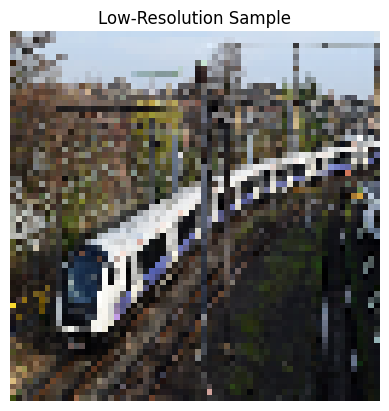

In [ ]:
# Show a sample image
plt.imshow(lr_images[12])
plt.title("Low-Resolution Sample")
plt.axis("off")
plt.show()

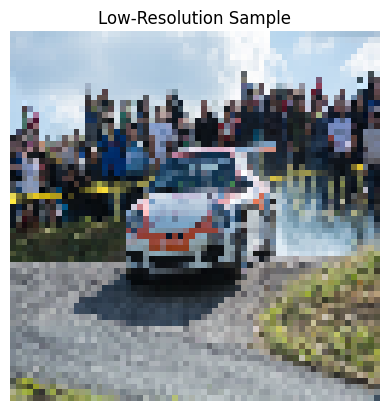

In [ ]:
# Show a sample image
plt.imshow(lr_images[8])
plt.title("Low-Resolution Sample")
plt.axis("off")
plt.show()

#**Generator**

In [ ]:
def build_generator():
    input_lr = Input(shape=(64, 64, 3))  # Adjusted for quick training

    x = Conv2D(64, kernel_size=9, padding="same", activation="relu")(input_lr)

    # Residual Blocks
    for _ in range(16):  # Reduce to speed up training
        res = Conv2D(64, kernel_size=3, padding="same")(x)
        res = BatchNormalization()(res)
        res = PReLU()(res)
        res = Conv2D(64, kernel_size=3, padding="same")(res)
        res = BatchNormalization()(res)
        x = Add()([x, res])

    # Upsampling
    x = Conv2D(256, kernel_size=3, padding="same")(x)
    x = Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)  # Pixel shuffle
    x = PReLU()(x)

    x = Conv2D(256, kernel_size=3, padding="same")(x)
    x = Lambda(lambda x: tf.nn.depth_to_space(x, 2))(x)
    x = PReLU()(x)

    output_hr = Conv2D(3, kernel_size=9, padding="same", activation="tanh")(x)

    return Model(input_lr, output_hr)

generator = build_generator()
generator.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │         15,616 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_re_lu (PReLU)           │ (None, 64, 64, 64)     │        262,144 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ p_re_lu[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 64)     │              0 │ conv2d[0][0],          │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ p_re_lu_1 (PReLU)         │ (None, 64, 64, 64)     │        262,144 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ p_re_lu_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 64, 64)     │              0 │ add[0][0],             │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 64, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 10,953,667 (41.78 MB)

 Trainable params: 10,949,571 (41.77 MB)

 Non-trainable params: 4,096 (16.00 KB)

#**Discriminator**

In [ ]:
def build_discriminator():
    input_hr = Input(shape=(256, 256, 3))

    x = Conv2D(64, kernel_size=3, strides=1, padding="same")(input_hr)
    x = LeakyReLU(alpha=0.2)(x)

    for filters in [64, 128, 256, 512]:  # Reduce complexity for speed
        x = Conv2D(filters, kernel_size=3, strides=2, padding="same")(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    output = Dense(1, activation="sigmoid")(x)

    return Model(input_hr, output)

discriminator = build_discriminator()
discriminator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │     134,218,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 135,811,521 (518.08 MB)

 Trainable params: 135,809,601 (518.07 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
def build_vgg_loss():
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
    vgg.trainable = False
    model = Model(vgg.input, vgg.get_layer("block5_conv4").output)
    return model

vgg_loss = build_vgg_loss()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#**Training model**

In [ ]:
generator.compile(loss="mse", optimizer=Adam(1e-4))

discriminator.compile(loss="binary_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])

batch_size = 8
epochs = 2000

for epoch in range(epochs):
    idx = np.random.randint(0, len(lr_images), batch_size)
    real = hr_images[idx]  # High-Resolution Ground Truth
    low_res = lr_images[idx]  # Low-Resolution Input

    # Convert to Tensor
    low_res_tensor = tf.convert_to_tensor(low_res, dtype=tf.float32)
    real_tensor = tf.convert_to_tensor(real, dtype=tf.float32)

    # Generate Fake High-Res Images
    fake_hr = generator(low_res_tensor, training=False)

    # Train Discriminator
    discriminator.trainable = True
    # Use label smoothing (1-sided) to improve training
    real_labels = tf.ones((batch_size, 1), dtype=tf.float32) * 0.9  # Smoothed to 0.9
    fake_labels = tf.zeros((batch_size, 1), dtype=tf.float32) + 0.1  # Smoothed to 0.1

    d_loss_real = discriminator.train_on_batch(real_tensor, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_hr, fake_labels)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Freeze Discriminator
    discriminator.trainable = False

    # Use only the generated HR image for loss, not VGG features**
    g_loss = generator.train_on_batch(low_res_tensor, real_tensor)


    if epoch % 50 == 0:
        print(f"Epoch {epoch}: D Loss {d_loss[0]}, G Loss {g_loss}")


Epoch 0: D Loss 31.971582412719727, G Loss 0.0215170755982399
Epoch 50: D Loss 5.827825546264648, G Loss 0.017051735892891884
Epoch 100: D Loss 4.351085186004639, G Loss 0.016861891373991966
Epoch 150: D Loss 3.606235980987549, G Loss 0.01689988374710083
Epoch 200: D Loss 3.295102596282959, G Loss 0.01691344752907753
Epoch 250: D Loss 3.063044548034668, G Loss 0.01671263575553894
Epoch 300: D Loss 2.8019397258758545, G Loss 0.016717078164219856
Epoch 350: D Loss 2.659268379211426, G Loss 0.016483807936310768
Epoch 400: D Loss 2.544187545776367, G Loss 0.016260722652077675
Epoch 450: D Loss 2.371913433074951, G Loss 0.016103290021419525
Epoch 500: D Loss 2.2609972953796387, G Loss 0.016113119199872017
Epoch 550: D Loss 2.147329330444336, G Loss 0.016065366566181183
Epoch 600: D Loss 2.0337634086608887, G Loss 0.015958255156874657
Epoch 650: D Loss 1.9974658489227295, G Loss 0.015887651592493057
Epoch 700: D Loss 1.948974370956421, G Loss 0.015872791409492493
Epoch 750: D Loss 1.90273356

#**Testing Sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


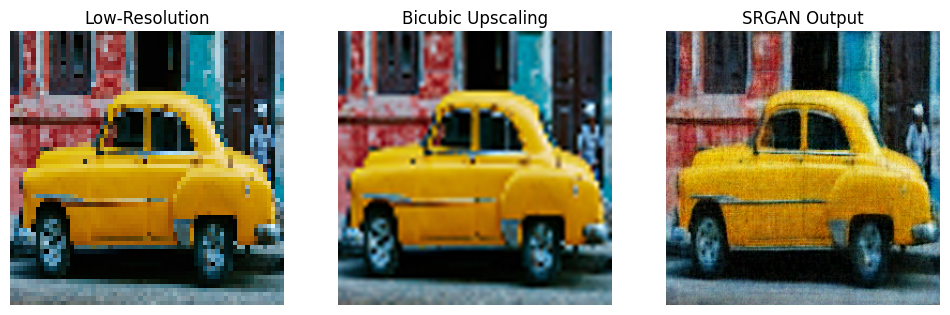

Saved SRGAN result at: srgan_results/srgan_output_epoch_1999.png


In [ ]:
# Create a directory to save results
save_dir = "srgan_results"
os.makedirs(save_dir, exist_ok=True)

# Select a test image
idx = 10
img_lr = lr_images[idx]
img_hr = hr_images[idx]

# Upscale using SRGAN
img_srgan = generator.predict(np.expand_dims(img_lr, axis=0))[0]

# Upscale using bicubic interpolation
img_bicubic = cv2.resize(img_lr, (img_hr.shape[1], img_hr.shape[0]), interpolation=cv2.INTER_CUBIC)

# Display and save results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_lr)
plt.title("Low-Resolution")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_bicubic)
plt.title("Bicubic Upscaling")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_srgan)
plt.title("SRGAN Output")
plt.axis("off")

# Save the figure with a unique filename (based on epoch, timestamp, etc.)

timestamp = time.strftime("%Y%m%d-%H%M%S")  # Format: YYYYMMDD-HHMMSS
image_path = os.path.join(save_dir, f"srgan_output_epoch_{epoch}.png")
plt.savefig(image_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved SRGAN result at: {image_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


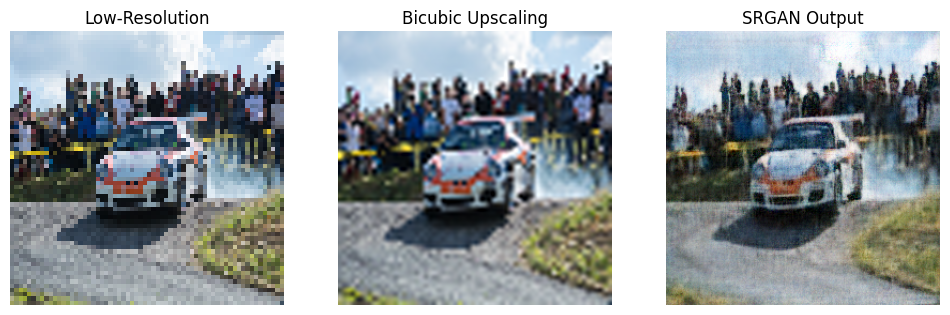

Saved SRGAN result at: srgan_results/srgan_output_epoch_1999.png


In [ ]:
import os
import time

# Create a directory to save results
save_dir = "srgan_results"
os.makedirs(save_dir, exist_ok=True)

# Select a test image
idx = 8
img_lr = lr_images[idx]
img_hr = hr_images[idx]

# Upscale using SRGAN
img_srgan = generator.predict(np.expand_dims(img_lr, axis=0))[0]

# Upscale using bicubic interpolation
img_bicubic = cv2.resize(img_lr, (img_hr.shape[1], img_hr.shape[0]), interpolation=cv2.INTER_CUBIC)

# Display and save results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_lr)
plt.title("Low-Resolution")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_bicubic)
plt.title("Bicubic Upscaling")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_srgan)
plt.title("SRGAN Output")
plt.axis("off")

# Save the figure with a unique filename (based on epoch, timestamp, etc.)

timestamp = time.strftime("%Y%m%d-%H%M%S")  # Format: YYYYMMDD-HHMMSS
image_path = os.path.join(save_dir, f"srgan_output_epoch_{epoch}.png")
plt.savefig(image_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved SRGAN result at: {image_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


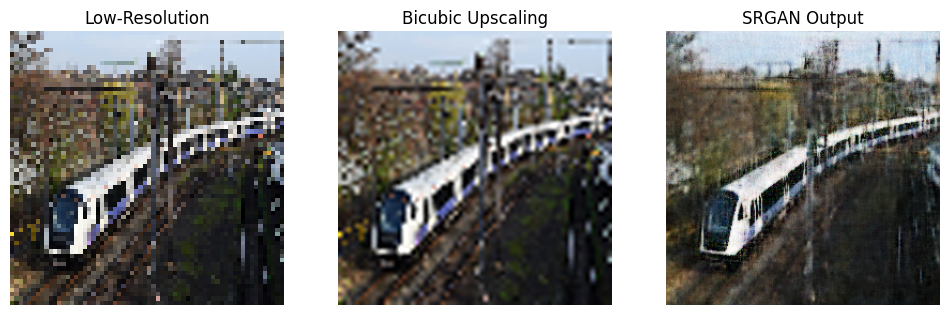

Saved SRGAN result at: srgan_results/srgan_output_epoch_1999.png


In [ ]:
# Create a directory to save results
save_dir = "srgan_results"
os.makedirs(save_dir, exist_ok=True)

# Select a test image
idx = 12
img_lr = lr_images[idx]
img_hr = hr_images[idx]

# Upscale using SRGAN
img_srgan = generator.predict(np.expand_dims(img_lr, axis=0))[0]

# Upscale using bicubic interpolation
img_bicubic = cv2.resize(img_lr, (img_hr.shape[1], img_hr.shape[0]), interpolation=cv2.INTER_CUBIC)

# Display and save results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_lr)
plt.title("Low-Resolution")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(img_bicubic)
plt.title("Bicubic Upscaling")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(img_srgan)
plt.title("SRGAN Output")
plt.axis("off")

# Save the figure with a unique filename (based on epoch, timestamp, etc.)

timestamp = time.strftime("%Y%m%d-%H%M%S")  # Format: YYYYMMDD-HHMMSS
image_path = os.path.join(save_dir, f"srgan_output_epoch_{epoch}.png")
plt.savefig(image_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved SRGAN result at: {image_path}")
